# Zeeguu Architecture Reconstruction using PyCallGraph (API Only)

This notebook performs dynamic architecture reconstruction for the Zeeguu API using PyCallGraph. We analyze the API components to understand their runtime behavior and dependencies.

Note: Ensure that [Graphviz](https://graphviz.org/download/) is installed and available on your system PATH. On Windows, you may need to download the installer and add the Graphviz bin folder to your PATH.

# Can't get it to properly work

In [1]:
import sys
import os

# Set the working directory to the notebook's directory
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
os.chdir(notebook_dir)
print(f"Working directory set to: {os.getcwd()}")

# Function to install packages using the current Python interpreter
def install_package(package):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        !{sys.executable} -m pip install {package}

# Install required packages
install_package('pycallgraph2')
install_package('matplotlib')
install_package('networkx')

# Reminder: Ensure Graphviz is installed on your system for generating graphs.

Working directory set to: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Tools
Installing pycallgraph2...
matplotlib is already installed.


ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'c:\\Python312\\Scripts\\pycallgraph'
Consider using the `--user` option or check the permissions.



networkx is already installed.


In [2]:
# Define the root directory and output directory for all pycallgraph outputs
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
OUTPUT_DIR = os.path.join(root_dir, "output", "pycallgraph")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory for pycallgraph: {OUTPUT_DIR}")

Output directory for pycallgraph: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\output\pycallgraph


In [3]:
# Import necessary libraries
import importlib
import matplotlib.pyplot as plt
import networkx as nx

try:
    from pycallgraph2 import PyCallGraph
    from pycallgraph2.output import GraphvizOutput
    from pycallgraph2.config import Config
    from pycallgraph2.globbing_filter import GlobbingFilter
except ImportError as e:
    print("Error: pycallgraph2 module not found. Make sure it is installed and restart the kernel.")
    raise e

c:\Python312\Lib\site-packages\pycallgraph2\output\output.py:100: SyntaxWarning: invalid escape sequence '\A'
  regex_user_expand = re.compile('\A~')


In [4]:
def setup_api_path():
    """Set up path to the Zeeguu API project"""
    current_dir = os.getcwd()
    # Navigate to the parent directory if needed
    if os.path.basename(current_dir).lower() == 'tools':
        parent_dir = os.path.dirname(current_dir)
    else:
        parent_dir = current_dir
    
    api_path = os.path.join(parent_dir, 'Data', 'api')
    
    if not os.path.exists(api_path):
        print(f"Warning: API path not found at {api_path}")
    
    # Add path to sys.path for module imports
    if api_path not in sys.path:
        sys.path.append(api_path)
    
    return api_path

api_path = setup_api_path()
print(f"API path: {api_path}")

API path: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\api


In [5]:
def configure_pycallgraph(module_prefix):
    """Configure PyCallGraph to include only modules with the given prefix"""
    config = Config()
    config.trace_filter = GlobbingFilter(include=[f"{module_prefix}*"])
    
    graphviz = GraphvizOutput(
        output_file=os.path.join(OUTPUT_DIR, f"{module_prefix}_call_graph.png"),
        font_size=10,
        node_color=lambda func_name: 'red' if func_name.startswith(module_prefix) else 'grey',
        edge_color=lambda from_func, to_func: 'black',
        drawer='dot'  
    )
    
    return config, graphviz

In [6]:
def scan_project_structure(project_path, exclusions=None):
    """Scan a project directory to find Python modules"""
    if exclusions is None:
        exclusions = ['__pycache__', '.git', '.venv', 'env', 'venv', 'tests']
    
    modules = []
    
    for root, dirs, files in os.walk(project_path):
        dirs[:] = [d for d in dirs if d not in exclusions]
        for file in files:
            if file.endswith('.py'):
                rel_path = os.path.relpath(os.path.join(root, file), project_path)
                module_path = os.path.splitext(rel_path.replace(os.sep, '.'))[0]
                modules.append(module_path)
    
    modules.sort()
    return modules

api_modules = scan_project_structure(api_path)

print(f"Found {len(api_modules)} modules in API project")
print("\nExample API modules:")
for module in api_modules[:10]:
    print(f"  - {module}")

Found 360 modules in API project

Example API modules:
  - __init__
  - env_var_defs_default
  - install_stanza_models
  - setup
  - start
  - tools.__init__
  - tools._playground
  - tools.activity_monitor
  - tools.add_feed
  - tools.add_images_to_articles


In [7]:
def identify_entry_points(modules):
    """Identify potential entry points in a list of modules"""
    entry_candidates = []
    
    # Only include modules that are part of zeeguu.api to avoid those requiring extra dependencies
    for module in modules:
        if module.startswith('zeeguu.api') and any(pattern in module.lower() for pattern in ['app', 'main', 'run', 'server', 'api', 'wsgi']):
            entry_candidates.append(module)
    
    return entry_candidates

api_entry_points = identify_entry_points(api_modules)

print("Potential API entry points:")
for entry in api_entry_points:
    print(f"  - {entry}")

Potential API entry points:
  - zeeguu.api.__init__
  - zeeguu.api.app
  - zeeguu.api.cross_domain_app
  - zeeguu.api.custom_fmd_graphs
  - zeeguu.api.endpoints.__init__
  - zeeguu.api.endpoints.accounts
  - zeeguu.api.endpoints.activity_tracking
  - zeeguu.api.endpoints.article
  - zeeguu.api.endpoints.bookmarks_and_words
  - zeeguu.api.endpoints.exercise_sessions
  - zeeguu.api.endpoints.exercises
  - zeeguu.api.endpoints.feature_toggles
  - zeeguu.api.endpoints.helpers.__init__
  - zeeguu.api.endpoints.helpers.activity_sessions
  - zeeguu.api.endpoints.nlp
  - zeeguu.api.endpoints.own_texts
  - zeeguu.api.endpoints.reading_sessions
  - zeeguu.api.endpoints.search
  - zeeguu.api.endpoints.sessions
  - zeeguu.api.endpoints.speech
  - zeeguu.api.endpoints.student
  - zeeguu.api.endpoints.system_languages
  - zeeguu.api.endpoints.teacher_dashboard.__init__
  - zeeguu.api.endpoints.teacher_dashboard._common_api_parameters
  - zeeguu.api.endpoints.teacher_dashboard._only_teachers_decorato

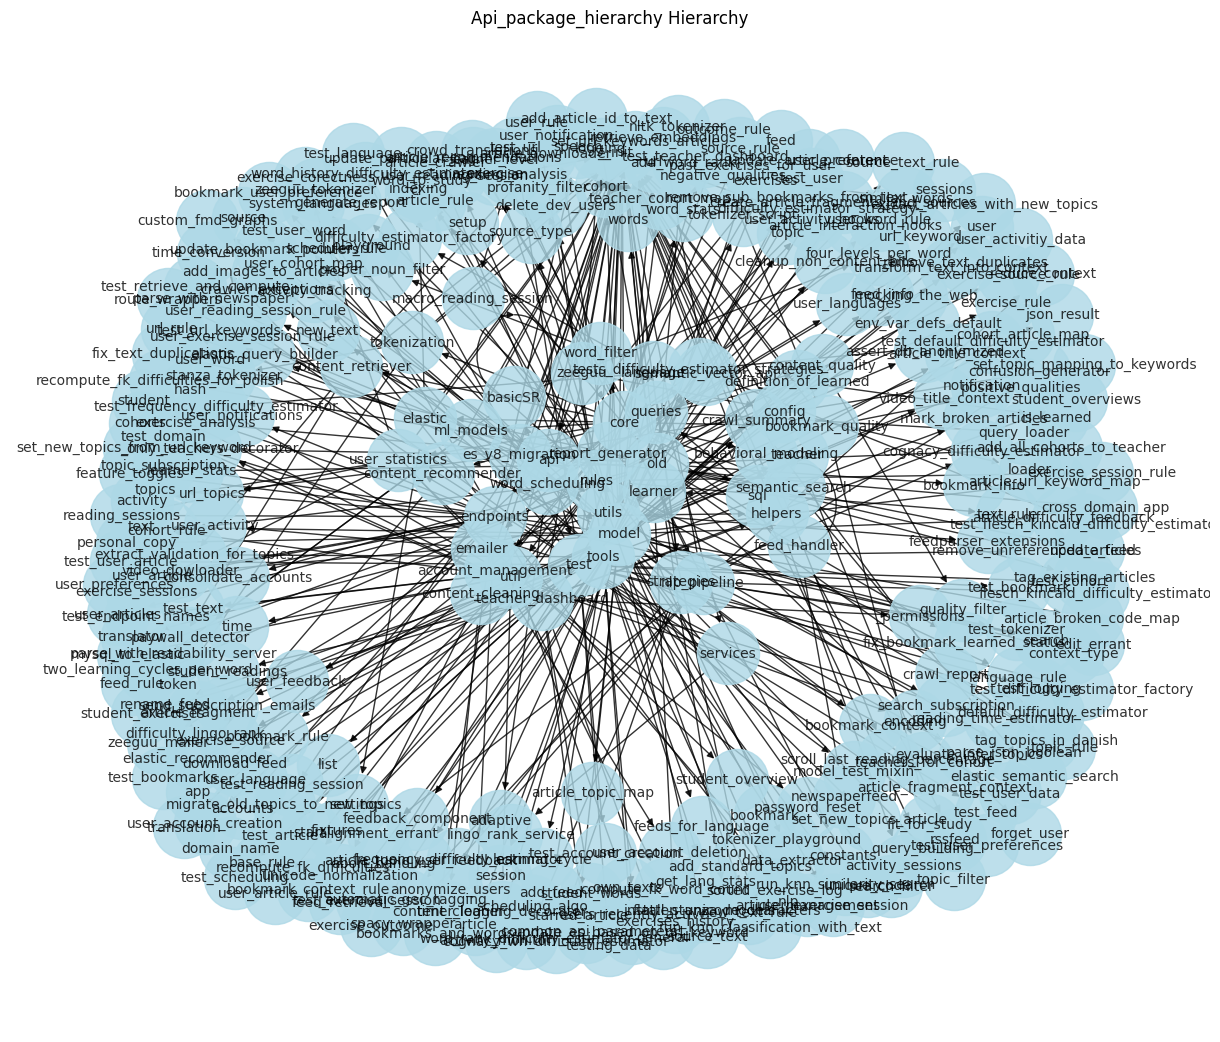

In [8]:
def extract_package_hierarchy(modules):
    """Extract package hierarchy from a list of modules"""
    packages = {}
    for module in modules:
        parts = module.split('.')
        current = packages
        for part in parts:
            if part not in current:
                current[part] = {}
            current = current[part]
    return packages

def visualize_package_hierarchy(packages, name="package_hierarchy"):
    """Create a graph visualization of the package hierarchy"""
    G = nx.DiGraph()
    
    def add_nodes_edges(current_pkg, parent=None):
        for pkg_name, children in current_pkg.items():
            G.add_node(pkg_name)
            if parent:
                G.add_edge(parent, pkg_name)
            add_nodes_edges(children, pkg_name)
    
    add_nodes_edges(packages)
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            font_size=10, node_size=2000, alpha=0.8)
    plt.title(f"{name.capitalize()} Hierarchy")
    plt.savefig(os.path.join(OUTPUT_DIR, f"{name}.png"))
    plt.show()

api_packages = extract_package_hierarchy(api_modules)

visualize_package_hierarchy(api_packages, "api_package_hierarchy")

In [9]:
import runpy

def run_pycallgraph_on_module(module_name, project_path):
    """Run PyCallGraph on a specific module"""
    root_package = module_name.split('.')[0]
    config, graphviz = configure_pycallgraph(root_package)
    
    if project_path not in sys.path:
        sys.path.insert(0, project_path)
    
    try:
        print(f"Attempting to import {module_name}...")
        # Import the module (its top-level code runs at import)
        module = importlib.import_module(module_name)
        
        with PyCallGraph(output=graphviz, config=config):
            if hasattr(module, 'main'):
                print(f"Executing {module_name}.main()")
                module.main()
            else:
                print(f"Module {module_name} has no main() function, executing module via runpy")
                # runpy.run_module will execute the module as if it were the __main__ module
                runpy.run_module(module_name, run_name="__main__", alter_sys=True)
        
        output_path = os.path.join(OUTPUT_DIR, f"{root_package}_call_graph.png")
        print(f"Call graph generated: {output_path}")
        return True
    except Exception as e:
        print(f"Error processing module {module_name}: {str(e)}")
        return False

def analyze_multiple_modules(entry_points, project_path, max_modules=5):
    """Try to analyze multiple entry points"""
    successful = 0
    for i, module in enumerate(entry_points):
        if i >= max_modules:
            break
        print(f"\nAnalyzing module {i+1}/{min(len(entry_points), max_modules)}: {module}")
        if run_pycallgraph_on_module(module, project_path):
            successful += 1
    print(f"\nAnalysis complete. Successfully analyzed {successful}/{min(len(entry_points), max_modules)} modules.")

# Example usage:
print("Analyzing API modules:")
analyze_multiple_modules(api_entry_points, api_path)


Analyzing API modules:

Analyzing module 1/5: zeeguu.api.__init__
Attempting to import zeeguu.api.__init__...
Module zeeguu.api.__init__ has no main() function, executing module via runpy


<frozen runpy>:128: RuntimeWarning: 'zeeguu.api.__init__' found in sys.modules after import of package 'zeeguu.api', but prior to execution of 'zeeguu.api.__init__'; this may result in unpredictable behaviour


Call graph generated: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\output\pycallgraph\zeeguu_call_graph.png

Analyzing module 2/5: zeeguu.api.app
Attempting to import zeeguu.api.app...
Error processing module zeeguu.api.app: No module named 'flask_cors'

Analyzing module 3/5: zeeguu.api.cross_domain_app
Attempting to import zeeguu.api.cross_domain_app...
Error processing module zeeguu.api.cross_domain_app: No module named 'flask'

Analyzing module 4/5: zeeguu.api.custom_fmd_graphs
Attempting to import zeeguu.api.custom_fmd_graphs...
Module zeeguu.api.custom_fmd_graphs has no main() function, executing module via runpy


c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\api\zeeguu\api\app.py:84: SyntaxWarning: invalid escape sequence '\-'
  ":([a-zA-Z_][a-zA-Z_0-9\-]*)@", ":****@", db_connection_string
<frozen runpy>:128: RuntimeWarning: 'zeeguu.api.custom_fmd_graphs' found in sys.modules after import of package 'zeeguu.api', but prior to execution of 'zeeguu.api.custom_fmd_graphs'; this may result in unpredictable behaviour


Call graph generated: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\output\pycallgraph\zeeguu_call_graph.png

Analyzing module 5/5: zeeguu.api.endpoints.__init__
Attempting to import zeeguu.api.endpoints.__init__...
Error processing module zeeguu.api.endpoints.__init__: No module named 'flask'

Analysis complete. Successfully analyzed 2/5 modules.


In [10]:
import os
import sys
import importlib
import runpy
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput
from pycallgraph2.config import Config
from pycallgraph2.globbing_filter import GlobbingFilter

def trace_specific_function(module_name, function_name, project_path, args=None):
    """Trace a specific function using PyCallGraph"""
    if args is None:
        args = []
    root_package = module_name.split('.')[0]
    config, graphviz = configure_pycallgraph(root_package)
    graphviz.output_file = os.path.join(OUTPUT_DIR, f"{module_name}_{function_name}_call_graph.png")
    
    if project_path not in sys.path:
        sys.path.insert(0, project_path)
    
    try:
        print(f"Attempting to import {module_name}...")
        module = importlib.import_module(module_name)
        # Retrieve the function by name
        function = getattr(module, function_name)
        print(f"Tracing function: {module_name}.{function_name}")
        with PyCallGraph(output=graphviz, config=config):
            result = function(*args)
        print(f"Function traced: {module_name}.{function_name}")
        print(f"Call graph generated: {graphviz.output_file}")
        return True
    except Exception as e:
        print(f"Error tracing function {module_name}.{function_name}: {str(e)}")
        return False

# -------------------------------------------------------------------
# Example Usage:
# For demonstration, we create a dummy module with a simple function,
# then we trace that function.
# -------------------------------------------------------------------

# Create a dummy module dynamically for testing purposes.
import types
dummy_module = types.ModuleType("dummy_module")

def dummy_function(x, y):
    print("Inside dummy_function: Adding", x, "and", y)
    return x + y

dummy_module.dummy_function = dummy_function

# Add our dummy module to sys.modules so it can be imported.
sys.modules["dummy_module"] = dummy_module

# For testing, use the current working directory as the project_path.
test_project_path = os.getcwd()

# Now trace the 'dummy_function' in 'dummy_module' with some example arguments.
trace_specific_function("dummy_module", "dummy_function", project_path=test_project_path, args=[2, 3])


Attempting to import dummy_module...
Tracing function: dummy_module.dummy_function
Inside dummy_function: Adding 2 and 3
Function traced: dummy_module.dummy_function
Call graph generated: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\output\pycallgraph\dummy_module_dummy_function_call_graph.png


True

In [11]:
def analyze_module_structure(module_name, project_path):
    """Analyze the structure of a module to identify its functions and classes"""
    if project_path not in sys.path:
        sys.path.insert(0, project_path)
    try:
        module = importlib.import_module(module_name)
        attrs = dir(module)
        classes = []
        functions = []
        for attr in attrs:
            if attr.startswith('_'):
                continue
            attr_value = getattr(module, attr)
            if isinstance(attr_value, type):
                classes.append(attr)
            elif callable(attr_value):
                functions.append(attr)
        print(f"\nModule: {module_name}")
        print(f"Classes ({len(classes)}): {', '.join(classes)}")
        print(f"Functions ({len(functions)}): {', '.join(functions)}")
        return classes, functions
    except Exception as e:
        print(f"Error analyzing module {module_name}: {str(e)}")
        return [], []

# Example analysis on key API modules (customize filter as needed)
api_key_modules = [mod for mod in api_modules if 'model' in mod.lower() or 'api' in mod.lower()]

print("Analyzing key API modules:")
for module in api_key_modules[:5]:
    analyze_module_structure(module, api_path)

Analyzing key API modules:
Error analyzing module install_stanza_models: No module named 'flask_sqlalchemy'

Module: zeeguu.api.__init__
Classes (0): 
Functions (0): 
Error analyzing module zeeguu.api.app: No module named 'flask_cors'
Error analyzing module zeeguu.api.cross_domain_app: No module named 'flask'

Module: zeeguu.api.custom_fmd_graphs
Classes (0): 
Functions (1): daily_visitors


In [12]:
def find_test_files(project_path):
    """Find all test files in a project"""
    test_files = []
    for root, dirs, files in os.walk(project_path):
        for file in files:
            if file.startswith('test_') and file.endswith('.py'):
                rel_path = os.path.relpath(os.path.join(root, file), project_path)
                module_path = os.path.splitext(rel_path.replace(os.sep, '.'))[0]
                test_files.append(module_path)
    return test_files

api_test_files = find_test_files(api_path)

print(f"Found {len(api_test_files)} test files in API project")
print("\nExample API test files:")
for test in api_test_files[:5]:
    print(f"  - {test}")

Found 31 test files in API project

Example API test files:
  - zeeguu.api.test.test_account_creation
  - zeeguu.api.test.test_article
  - zeeguu.api.test.test_bookmark
  - zeeguu.api.test.test_bookmarks
  - zeeguu.api.test.test_endpoint_names


In [13]:
def analyze_test_file(test_module, project_path):
    """Run a test module and generate a call graph to understand architecture"""
    root_package = test_module.split('.')[0]
    config = Config()
    config.trace_filter = GlobbingFilter(include=[f"{root_package}*"], exclude=["*.test_*"])
    
    graphviz = GraphvizOutput(
        output_file=os.path.join(OUTPUT_DIR, f"{test_module}_call_graph.png"),
        font_size=8,
        node_color=lambda func_name: 'red' if root_package in func_name else 'grey',
        edge_color=lambda caller, callee: 'black',
        drawer='dot'
    )
    
    if project_path not in sys.path:
        sys.path.insert(0, project_path)
    
    try:
        print(f"Attempting to import {test_module}...")
        module = importlib.import_module(test_module)
        
        with PyCallGraph(output=graphviz, config=config):
            import pytest
            pytest.main(['-xvs', os.path.join(project_path, test_module.replace('.', os.sep) + '.py')])
        
        print(f"Call graph generated: {test_module}_call_graph.png")
        return True
    except Exception as e:
        print(f"Error processing test module {test_module}: {str(e)}")
        return False

print("Analyzing API test files:")
for test in api_test_files[:3]:
    analyze_test_file(test, api_path)

Analyzing API test files:
Attempting to import zeeguu.api.test.test_account_creation...
Error processing test module zeeguu.api.test.test_account_creation: No module named 'pytest'
Attempting to import zeeguu.api.test.test_article...
Error processing test module zeeguu.api.test.test_article: No module named 'flask_sqlalchemy'
Attempting to import zeeguu.api.test.test_bookmark...
Error processing test module zeeguu.api.test.test_bookmark: No module named 'fixtures'
